# 모델 성능 개선하기
## 1. 형태소 분석기 변경해보기
- 형태소 분석기간의 장단점이 무엇인지
- 처리속도와 성능의 변화 비교
## 2. 불용어 추가
- 불용어가 50개가 될 떄까지 추가
- 지나치게 빈도가 낮은 단어, 지나치게 빈도가 높은 단어 둘 중 어떤 단어가 불용ㅇ어로 선택할 경우 모델 성능 향상에 효과가 더 좋을지 고민
## 3. 다른 날짜 데이터 추가
- 2023 11 28 외의 날짜 추가 수집 후 어떻게 합칠까?
- 데이터는 어떻게 섞을까?

## Criteria
- 형태소 분석기 선택과 불용어 제거가 체계적으로 진행됨
- 일자와 분량에서 텍스트 에터 다양성 향상을 위한 노력이 확인됨
- F-1 score 기준 83% 이상의 정확도가 확인됨

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
    urllist= []
    print(code, page_num, date)
    for i in range(1, page_num + 1):
        try:
            url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
            news = requests.get(url, headers=headers)

            # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
            soup = BeautifulSoup(news.content, 'html.parser')

            # CASE 1
            news_list = soup.select('.newsflash_body .type06_headline li dl')
            # CASE 2
            news_list.extend(soup.select('.newsflash_body .type06 li dl'))

        # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
            for line in news_list:
                urllist.append(line.a.get('href'))
        except:
            pass
    return urllist

from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
    text_list = []
    count = 0
    for url in urllist:
        try:
            article = Article(url, language='ko')
            article.download()
            article.parse()
            text_list.append(article.title)
            count+=1
        except:
            print('error:code{} -> current count: {} :::moving on',code,count)
            pass

    #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
    df = pd.DataFrame({'news': text_list})

    #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
    df['code'] = idx2word[str(code)]
    return df

In [2]:
idx2word = {'100':'정치','101' : '경제', '102' : '사회', '103' : '생활/문화','104' : '세계','105' : 'IT/과학'}

In [3]:
code_list = [int(i) for i in idx2word.keys()]
code_list

In [5]:
def make_total_data(page_num, code_list, date):
    df = None

    for code in code_list:
        url_list = make_urllist(page_num, code, date)
        df_temp = make_data(url_list, code)
        print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp

    return df

In [2]:
#date 변환
from datetime import datetime, timedelta

start_date = datetime(2023, 12, 1)
end_date = datetime(2023, 12, 31)

date_list = []

while start_date <= end_date:
    formatted_date = start_date.strftime('%Y%m%d')
    date_list.append(formatted_date)
    start_date += timedelta(days=1)

print(len(date_list))

31


In [3]:
# import os

# # 데이터프레임 파일을 csv 파일로 저장합니다.
# # 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.

# for i in date_list :
#     df = make_total_data(1, code_list, i) # datelist 만큼 6개의 주제에 대해 (60)
#     csv_path = os.getenv("HOME") + "/aiffel/news_crawler/"+str(i)+"_news_data.csv"
    
#     df.to_csv(csv_path, index=False)
    
#     if os.path.exists(csv_path):
#         print('{} File Saved!'.format(csv_path))

# 데이터 불러오기

In [1]:
#date 변환
from datetime import datetime, timedelta

start_date = datetime(2023, 12, 1)
end_date = datetime(2023, 12, 31)

date_list = []

while start_date <= end_date:
    formatted_date = start_date.strftime('%Y%m%d')
    date_list.append(formatted_date)
    start_date += timedelta(days=1)

print(len(date_list))

31


In [2]:
import os
import pandas as pd
df = None
for i in date_list:
    #path
    csv_path = os.getenv("HOME") + "/aiffel/news_crawler/"+str(i)+"_news_data.csv"
    df_temp = pd.read_table(csv_path, sep=',')
    if df is not None:
        df = pd.concat([df, df_temp])
    else:
        df = df_temp

In [3]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/tmp/ipykernel_388/3527289840.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [4]:
df

,news,code
0,공군사령부 방문한 북한 김정은,정치
1,김정은 딸 주애와 악수하는 김광혁 공군사령관,정치
2,김정은 딸 주애에게 거수경례하는 북한 공군사령부 정치위원,정치
3,공군사령부 방문한 북한 김정은과 딸 주애,정치
4,공군 비행사들과 기념촬영하는 김정은과 딸 주애,정치
...,...,...
115,뉴욕타임스 챗 개발사 소송에 조선경향 네이버도 허락 없이 뉴스활용 부당,IT/과학
116,글로벌 경제불황은 사회문제로개인 만족 충성도는 상승,IT/과학
117,민간 은행은 상상도 못할 일개월 동안 회 먹통난 우체국 금융시스템,IT/과학
118,서울콘 올해 서울시가 키운 최고의 크리에이터는 크리에이티브 포스 어워즈,IT/과학


In [5]:
df.drop_duplicates(subset=['news'], inplace=True)

In [6]:
df = df.reset_index(drop=True)
df.head()

,news,code
0,공군사령부 방문한 북한 김정은,정치
1,김정은 딸 주애와 악수하는 김광혁 공군사령관,정치
2,김정은 딸 주애에게 거수경례하는 북한 공군사령부 정치위원,정치
3,공군사령부 방문한 북한 김정은과 딸 주애,정치
4,공군 비행사들과 기념촬영하는 김정은과 딸 주애,정치


<AxesSubplot:>

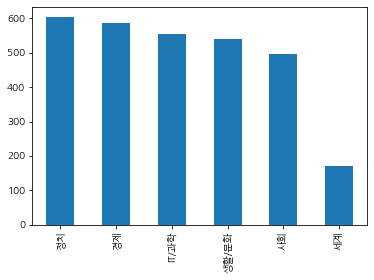

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [8]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    555
1     경제    587
2     사회    497
3  생활/문화    539
4     세계    171
5     정치    603


In [34]:
stopwords = ['ㅎㅎ', 'ㅎㅎㅎ','에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [35]:
len(stopwords)

33

In [36]:
#stopword
# stop = []
# f = open("./stopword.txt",'r')
# for i in f :
#     stop.append(i.strip('\n'))
# f.close()
# stop
#stopwords = stop

In [37]:
df =df.dropna(axis=0)

In [38]:
df

,news,code
0,공군사령부 방문한 북한 김정은,정치
1,김정은 딸 주애와 악수하는 김광혁 공군사령관,정치
2,김정은 딸 주애에게 거수경례하는 북한 공군사령부 정치위원,정치
3,공군사령부 방문한 북한 김정은과 딸 주애,정치
4,공군 비행사들과 기념촬영하는 김정은과 딸 주애,정치
...,...,...
2947,뉴욕타임스 챗 개발사 소송에 조선경향 네이버도 허락 없이 뉴스활용 부당,IT/과학
2948,글로벌 경제불황은 사회문제로개인 만족 충성도는 상승,IT/과학
2949,민간 은행은 상상도 못할 일개월 동안 회 먹통난 우체국 금융시스템,IT/과학
2950,서울콘 올해 서울시가 키운 최고의 크리에이터는 크리에이티브 포스 어워즈,IT/과학


In [39]:
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from konlpy.tag import Okt
from konlpy.tag import Komoran
from konlpy.tag import Mecab

mecab = Mecab()
hannanum = Hannanum()
#hannanum.morphs
kkma = Kkma()
#kkma.morphs
okt = Okt()
#okt.morphs
komoran = Komoran(userdic='/tmp/dic.txt')

java.io.FileNotFoundException: /tmp/dic.txt (No such file or directory)
	at java.base/java.io.FileInputStream.open0(Native Method)
	at java.base/java.io.FileInputStream.open(FileInputStream.java:219)
	at java.base/java.io.FileInputStream.<init>(FileInputStream.java:157)
	at java.base/java.io.FileInputStream.<init>(FileInputStream.java:112)
	at java.base/java.io.FileReader.<init>(FileReader.java:60)
	at kr.co.shineware.nlp.komoran.core.Komoran.setUserDic(Komoran.java:616)


In [40]:
tag = [mecab, hannanum, kkma, okt, komoran]
tag_name = ['mecab', 'hannanum', 'kkma', 'okt', 'komoran']

# 모델 훈련

In [41]:
import time
def preprocessing(data,tokenizer,tag_name,stopwords):
    text_data = []
    start = time.time()
    for sentence in data:
        temp_data = []
        #- 토큰화
        #print(sentence)
        try:
            temp_data = tokenizer.morphs(sentence) 
        #- 불용어 제거
        except :
            print(sentence)
        temp_data = [word for word in temp_data if not word in stopwords]
        #print(temp_data)
        text_data.append(temp_data)
    end = time.time()
    text_data = list(map(' '.join, text_data))
    print(f"{tag_name} : {end - start:.5f} sec")
    return text_data

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf
for tagg,tag_namee in zip(tag,tag_name):
    text_data = preprocessing(df['news'],tagg,tag_namee)
    X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)
    print('훈련용 뉴스 기사의 개수 :', len(X_train))
    print('테스트용 뉴스 기사의 개수 : ', len(X_test))
    print('훈련용 레이블의 개수 : ', len(y_train))
    print('테스트용 레이블의 개수 : ', len(y_test))
    #- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)

    #- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    #- 나이브 베이즈 분류기를 수행합니다.
    #- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
    clf = MultinomialNB().fit(X_train_tfidf, y_train)
    y_pred = clf.predict(tfidf_vectorizer(X_test))
    print(metrics.classification_report(y_test, y_pred))

mecab : 0.24642 sec
훈련용 뉴스 기사의 개수 : 2213
테스트용 뉴스 기사의 개수 :  738
훈련용 레이블의 개수 :  2213
테스트용 레이블의 개수 :  738
              precision    recall  f1-score   support

       IT/과학       0.57      0.69      0.62       136
          경제       0.57      0.64      0.60       158
          사회       0.65      0.44      0.52       121
       생활/문화       0.59      0.59      0.59       131
          세계       1.00      0.07      0.13        44
          정치       0.70      0.86      0.78       148

    accuracy                           0.62       738
   macro avg       0.68      0.55      0.54       738
weighted avg       0.64      0.62      0.60       738



# MECAB

In [92]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.57      0.69      0.62       136
          경제       0.57      0.64      0.60       158
          사회       0.65      0.44      0.52       121
       생활/문화       0.59      0.59      0.59       131
          세계       1.00      0.07      0.13        44
          정치       0.70      0.86      0.78       148

    accuracy                           0.62       738
   macro avg       0.68      0.55      0.54       738
weighted avg       0.64      0.62      0.60       738



# kkma

In [28]:
y_pred = clf.predict(tfidf_vectorizer(X_test)) #101.53963 sec
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.54      0.67      0.59       136
          경제       0.55      0.61      0.58       158
          사회       0.68      0.44      0.53       121
       생활/문화       0.63      0.61      0.62       131
          세계       1.00      0.07      0.13        44
          정치       0.71      0.88      0.78       148

    accuracy                           0.62       738
   macro avg       0.68      0.55      0.54       738
weighted avg       0.64      0.62      0.60       738



# 불용어 체크

In [21]:
text_data = preprocessing(df['news'],tag[0],tag_name[0])
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(text_data)

mecab : 0.24826 sec


In [25]:
count_vect.get_feature_names_out()

array(['ㅎㅎ', 'ㅎㅎㅎ', '가격', ..., '힘듭니다', '힘쓰', '힙합'], dtype=object)

In [32]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the occurrences of each word
word_counts = Counter(count_vect.get_feature_names_out())

# Extract words and their corresponding counts
words, counts = zip(*word_counts.items())

sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k], reverse=True)
sorted_words = [words[i] for i in sorted_indices]
sorted_counts = [counts[i] for i in sorted_indices]

most_common_word = sorted_words[:10]
print(f"The word with the most count is: {most_common_word}")

# Print the word with the least count
least_common_word = sorted_words[-10:]
print(f"The word with the least count is: {least_common_word}")


The word with the most count is: ['ㅎㅎ', 'ㅎㅎㅎ', '가격', '가결', '가계', '가공', '가구', '가금', '가까워', '가까이']
The word with the least count is: ['희생', '희생자', '희토류', '히트', '힐링', '힘든', '힘들', '힘듭니다', '힘쓰', '힙합']


In [ ]:
stopwords = ['ㅎㅎ', 'ㅎㅎㅎ','에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [ ]:
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf
for tagg,tag_namee in zip(tag,tag_name):
    text_data = preprocessing(df['news'],tagg,tag_namee)
    X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)
    print('훈련용 뉴스 기사의 개수 :', len(X_train))
    print('테스트용 뉴스 기사의 개수 : ', len(X_test))
    print('훈련용 레이블의 개수 : ', len(y_train))
    print('테스트용 레이블의 개수 : ', len(y_test))
    #- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)

    #- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    #- 나이브 베이즈 분류기를 수행합니다.
    #- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
    clf = MultinomialNB().fit(X_train_tfidf, y_train)
    y_pred = clf.predict(tfidf_vectorizer(X_test))
    print(metrics.classification_report(y_test, y_pred))

# 회고

욕심을 너무 부려서 6가지의 클래스를 넣더니 점수가 많이 낮게 나왔다. 클래스당 데이터의 갯수가 다른 것도 한몫 한것 같다. 시간적인 것도 생각해서 진행을 해야 겠다.